## Summary

### Definition of model


### Results



In [28]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.simulation import run_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [29]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

## Variables

In [30]:
# Space and cells
space_shape = np.array([101,101])
cells = np.array([7,7])
space_center = (space_shape / 2).astype(int)

# Source
source_radius = 2
source_cell_resolution = np.array([3,3])
source_cell_shape = (np.array(space_shape) / cells).astype(int) #! Default but can be changed

## Building probabilities

In [31]:
indices = np.arange(space_shape[0])
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal(space_center, 50)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

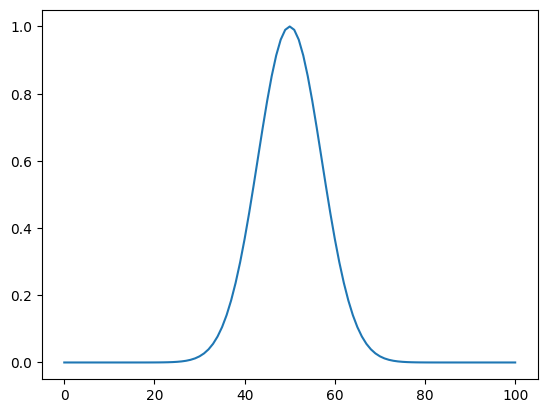

In [32]:
plt.plot(probability_map[50])

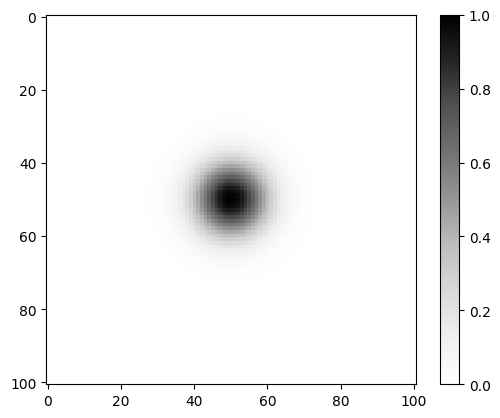

In [33]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

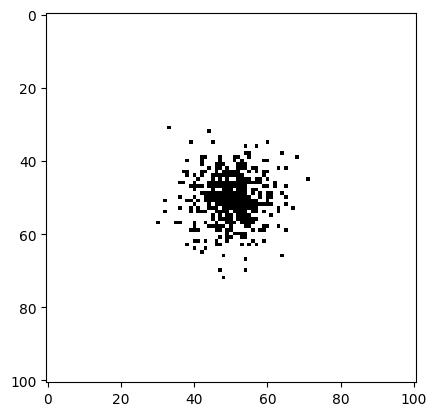

In [34]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cells

In [35]:
def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_radius: int = -1
                       ) -> np.ndarray:
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        if ax_overflow > 0:
            sizes[:int(np.floor(ax_overflow/2))] += 1
            sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

    grid_cells = np.full(space_shape, -1)
    for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # Grid to cell mapping
        grid_cells[*slices] = i

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    if source_radius >= 0:
        # Indices are at source
        at_source = np.sum(((space_shape / 2) - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
        grid_cells[*spacial_indices_array[at_source].T] = -1

    return grid_cells

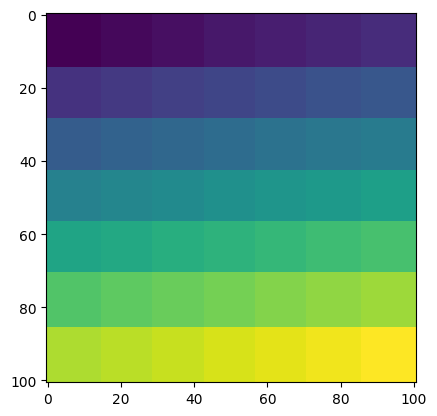

In [36]:
# grid_cells = build_grid_mapping(source_position=np.array([20,20]))
# grid_cells = build_grid_mapping(cells=np.array([5,5]))
# grid_cells = build_grid_mapping(source_cell_resolution=np.array([5,5]))
# grid_cells = build_grid_mapping()
grid_cells = build_grid_mapping(space_shape=space_shape, cells=cells)

# Visualize
plt.imshow(grid_cells)
plt.show()

### State labels

In [37]:
# Get the list of all indices
indices_list = list(np.ndindex((*cells, *cells)))

In [38]:
cell_indices = list(np.ndindex((*cells,)))
source_cell_indices = list(np.ndindex((*source_cell_resolution,)))

state_labels = []
for (s_y, s_x) in cell_indices:
    state_labels.append(f's_{s_y}_{s_x}')
state_labels += [f'sr_{source_y}_{source_x}' for (source_y, source_x) in source_cell_indices]
state_labels.append('goal')

# Print the indices list
state_labels[:10]

['s_0_0',
 's_0_1',
 's_0_2',
 's_0_3',
 's_0_4',
 's_0_5',
 's_0_6',
 's_1_0',
 's_1_1',
 's_1_2']

### Actions

In [39]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Transition probabilities

In [57]:
cardinal_action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])

cell_count = np.prod(cells)
sub_cell_count = np.prod(source_cell_resolution)

# Building grid cells and associated indices
grid_cells = build_grid_mapping(space_shape=space_shape, cells=cells)

spacial_indices = list(np.ndindex(tuple(space_shape)))
spacial_indices_array = np.array(spacial_indices).astype(int)

cells_from_indices = grid_cells[*spacial_indices_array.T]
has_neighbours = np.zeros((cell_count, len(cardinal_action_set)), dtype=bool)

# Building sub grid cells and associated indices
sub_grid_cells = build_grid_mapping(space_shape=source_cell_shape, cells=source_cell_resolution, source_radius=source_radius)

sub_spacial_indices = list(np.ndindex(tuple(source_cell_shape)))
sub_spacial_indices_array = np.array(sub_spacial_indices).astype(int)

sub_cells_from_indices = sub_grid_cells[*sub_spacial_indices_array.T]

for a, move in enumerate(cardinal_action_set):
    # Applying the moves to the indices
    moved_indices = spacial_indices_array + move
    moved_indices_clipped = np.clip(moved_indices, 0, space_shape-1)

    # Converting moved indices to cell indices
    cells_from_indices_after_move = grid_cells[*moved_indices_clipped.T]

    # Building a confusion matrix of the moves
    conf = confusion_matrix(cells_from_indices, cells_from_indices_after_move, labels=np.arange(cell_count))

    # Computing which are neighbouring cells
    reachable_cells = np.argwhere(conf != 0.0)
    reachable_cells = reachable_cells[reachable_cells[:,0] != reachable_cells[:,1]]

    has_neighbours[np.unique(reachable_cells[:,0]), a] = True

# Computing which cell have neighbours to compute the appropriate overlap
neighbour_num = np.sum(has_neighbours, axis=1)
is_edge = (neighbour_num == 3)
is_corner = (neighbour_num == 2)
is_edge_vert = is_edge & np.any(~has_neighbours[:,[1,3]], axis=1) # either East or West actions have NO neighbours
is_edge_hori = is_edge & np.any(~has_neighbours[:,[0,2]], axis=1) # either North or South actions have NO neighbours

# overlap computation
cell_h, cell_w = (space_shape / cells)
sub_cell_h, sub_cell_w = source_cell_shape

overlap_h_min = min(cell_h, sub_cell_h)
overlap_w_min = min(cell_w, sub_cell_w)

overlap_a = cell_w + sub_cell_w
overlap_b = cell_h + sub_cell_h
overlap_c = overlap_a - (2 * overlap_w_min)
overlap_d = overlap_b - (2 * overlap_h_min)
overlap_h = (overlap_w_min * overlap_h_min)

overlap = (overlap_h / 3) * ((overlap_a * overlap_b) + (overlap_c * overlap_d) + (((overlap_a * overlap_d) + (overlap_b * overlap_c)) / 2))

# edge overlap removal computation
edge_overlap_w = (overlap_h * overlap_h_min * overlap_c) / 8
edge_overlap_h = (overlap_h * overlap_w_min * overlap_d) / 8
edge_overlap_corner = (((overlap_h / 2)**2) / 3) # TODO Rework this (corner is not right)

# Computing the actual cell overlaps
cell_overlaps = np.full(cell_count, overlap)
cell_overlaps[is_edge_hori] -= (edge_overlap_w + (2 * edge_overlap_corner)) # The edge overlap on the width and 2 corners
cell_overlaps[is_edge_vert] -= (edge_overlap_h + (2 * edge_overlap_corner)) # The edge overlap on the height and 2 corners
cell_overlaps[is_corner] -= (edge_overlap_h + edge_overlap_w + (3 * edge_overlap_corner)) # The edge overlap on the height and the width and 3 corners

average_cell_overlaps = cell_overlaps / np.prod(space_shape)

In [58]:
# Computing moving out to other cell probabilities
p_out = np.zeros((cell_count, len(action_labels), cell_count))
p_sub = np.zeros((cell_count, len(action_labels)))
p_sub_to_sub = np.zeros(((sub_cell_count + 2), len(action_labels), (sub_cell_count + 2)))

cell_indices_arr = np.array(cell_indices)
sub_cell_indices_arr = np.array(source_cell_indices)

for a, move in enumerate(action_set):
    # Decomposing the move vector to it's unit components
    non_zero_components = np.argwhere(move)[0]
    unit_move = np.zeros(len(move), dtype=int)
    unit_move[non_zero_components] = (move[non_zero_components] / np.abs(move[non_zero_components]))

    has_diag_neighbour = np.ones(cell_count, dtype=bool)
    sub_has_diag_neighbour = np.ones(sub_cell_count, dtype=bool)

    # Extracting the vertical and horizontal components of the move vector
    vert_move_component = np.abs(move[0])
    hori_move_component = np.abs(move[1])

    # Compute minima for overlap computations
    vert_overlap_w_min = min((cell_w - hori_move_component), sub_cell_w)
    vert_overlap_h_min = min(vert_move_component, sub_cell_h)

    hori_overlap_w_min = min(hori_move_component, sub_cell_w)
    hori_overlap_h_min = min((cell_h - vert_move_component), sub_cell_h)

    # Computing cells dimensions
    all_cell_w = np.full(cell_count, cell_w)
    all_cell_h = np.full(cell_count, cell_h)

    # Generate arrays to know which cells have neighbours with the inverse moves
    inv_has_vert_neighour = np.ones(cell_count, dtype=bool)
    inv_has_hori_neighour = np.ones(cell_count, dtype=bool)

    if 0 in non_zero_components:
        # Check which cardinal action is associated with the vertical component of the movement vector
        vert_unit_move = np.array([unit_move[0], 0])
        vert_cardinal_action = np.argwhere(np.all(cardinal_action_set == vert_unit_move, axis=1))[0,0]
        inv_vert_cardinal_action = np.argwhere(np.all(cardinal_action_set == -vert_unit_move, axis=1))[0,0]

        # Checking for neighbours
        has_vert_neighbour = has_neighbours[:,vert_cardinal_action]
        inv_has_vert_neighour = has_neighbours[:,inv_vert_cardinal_action]
        has_diag_neighbour &= has_vert_neighbour

        vert_neighbour = np.full(cell_count, -1, dtype=int)
        vert_moved_cell_indices = cell_indices_arr + vert_unit_move
        vert_neighbour[has_vert_neighbour] = np.arange(cell_count).reshape(cells)[*vert_moved_cell_indices[has_vert_neighbour,:].T]

        # Removing move component from cell heights if has no neighbour
        all_cell_h[~has_vert_neighbour] -= vert_move_component

        # Computing overlap
        vert_overlap_a = (cell_w - hori_move_component) + sub_cell_w
        vert_overlap_b = vert_move_component + sub_cell_h
        vert_overlap_c = vert_overlap_a - (2 * vert_overlap_w_min)
        vert_overlap_d = vert_overlap_b - (2 * vert_overlap_h_min)
        vert_overlap_h = (vert_overlap_w_min * vert_overlap_h_min)

        vert_overlap = (vert_overlap_h / 3) * ((vert_overlap_a * vert_overlap_b) + (vert_overlap_c * vert_overlap_d) + (((vert_overlap_a * vert_overlap_d) + (vert_overlap_b * vert_overlap_c)) / 2))

        # TODO: Ensure vert_move * (cell_w - hori_move) doesnt have a negative component (when move is longer than cell shape)
        # Compute area of point vertically moving out MINUS the average overlap of the subgrid of said area of points
        avg_vert_overlap = vert_overlap / np.prod(space_shape)
        vert_out_prob = ((vert_move_component * (cell_w - hori_move_component)) - avg_vert_overlap) / ((cell_w * cell_h) - average_cell_overlaps) # average cell overlaps is an array
        p_out[has_vert_neighbour, a, vert_neighbour[has_vert_neighbour]] = vert_out_prob[has_vert_neighbour]

    if 1 in non_zero_components:
        # Check which cardinal action is associated with the horizontal component of the movement vector
        hori_unit_move = np.array([0, unit_move[1]])
        hori_cardinal_action = np.argwhere(np.all(cardinal_action_set == hori_unit_move, axis=1))[0,0]
        inv_hori_cardinal_action = np.argwhere(np.all(cardinal_action_set == -hori_unit_move, axis=1))[0,0]

        # Checking for neighbours
        has_hori_neighbour = has_neighbours[:,hori_cardinal_action]
        inv_has_hori_neighour = has_neighbours[:,inv_hori_cardinal_action]
        has_diag_neighbour &= has_hori_neighbour

        hori_neighbour = np.full(cell_count, -1, dtype=int)
        hori_moved_cell_indices = cell_indices_arr + hori_unit_move
        hori_neighbour[has_hori_neighbour] = np.arange(cell_count).reshape(cells)[*hori_moved_cell_indices[has_hori_neighbour,:].T]

        # Removing move component from cell widths if has no neighbour
        all_cell_w[~has_hori_neighbour] -= hori_move_component

        # Compute overlap
        hori_overlap_a = hori_move_component + sub_cell_w
        hori_overlap_b = (cell_h - vert_move_component) + sub_cell_h
        hori_overlap_c = hori_overlap_a - (2 * hori_overlap_w_min)
        hori_overlap_d = hori_overlap_b - (2 * hori_overlap_h_min)
        hori_overlap_h = (hori_overlap_w_min * hori_overlap_h_min)

        hori_overlap = (hori_overlap_h / 3) * ((hori_overlap_a * hori_overlap_b) + (hori_overlap_c * hori_overlap_d) + (((hori_overlap_a * hori_overlap_d) + (hori_overlap_b * hori_overlap_c)) / 2))

        # TODO: Ensure hori_move * (cell_h - vert_move) doesnt have a negative component (when move is longer than cell shape)
        # Compute area of point horizontally moving out MINUS the average overlap of the subgrid of said area of points
        avg_hori_overlap = hori_overlap / np.prod(space_shape)
        hori_out_prob = ((hori_move_component * (cell_h - vert_move_component)) - avg_hori_overlap) / ((cell_w * cell_h) - average_cell_overlaps) # average cell overlaps is an array
        p_out[has_hori_neighbour, a, hori_neighbour[has_hori_neighbour]] = hori_out_prob[has_hori_neighbour]

    # Diagonal movement
    if len(non_zero_components) == 2:
        diag_neighbour = np.full(cell_count, -1, dtype=int)
        diag_moved_cell_indices = cell_indices_arr + unit_move
        diag_neighbour[has_diag_neighbour] = np.arange(cell_count).reshape(cells)[*diag_moved_cell_indices[has_diag_neighbour,:].T]

        # Compute overlap
        diag_overlap_a = hori_move_component + sub_cell_w
        diag_overlap_b = vert_move_component + sub_cell_h
        diag_overlap_c = diag_overlap_a - (2 * hori_overlap_w_min)
        diag_overlap_d = diag_overlap_b - (2 * vert_overlap_h_min)
        diag_overlap_h = (hori_overlap_w_min * vert_overlap_h_min)

        diag_overlap = (diag_overlap_h / 3) * ((diag_overlap_a * diag_overlap_b) + (diag_overlap_c * diag_overlap_d) + (((diag_overlap_a * diag_overlap_d) + (diag_overlap_b * diag_overlap_c)) / 2))

        # TODO: Ensure (vert_move * hori_move) doesnt have a negative component (when move is longer than cell shape)
        # Compute area of point diagonally moving out MINUS the average overlap of the subgrid of said area of points
        avg_diag_overlap = diag_overlap / np.prod(space_shape)
        diag_out_prob = ((vert_move_component * hori_move_component) - avg_diag_overlap) / ((cell_w * cell_h) - average_cell_overlaps) # average cell overlaps is an array
        p_out[has_diag_neighbour, a, diag_neighbour[has_diag_neighbour]] = diag_out_prob[has_diag_neighbour]


    # overlap computation of the cell move out points
    c_move_overlap_h_min = np.min([all_cell_h, np.full_like(all_cell_h, sub_cell_h)], axis=0)
    c_move_overlap_w_min = np.min([all_cell_w, np.full_like(all_cell_h, sub_cell_w)], axis=0)

    c_move_overlap_a = all_cell_w + sub_cell_w
    c_move_overlap_b = all_cell_h + sub_cell_h
    c_move_overlap_c = c_move_overlap_a - (2 * c_move_overlap_w_min)
    c_move_overlap_d = c_move_overlap_b - (2 * c_move_overlap_h_min)
    c_move_overlap_h = (c_move_overlap_w_min * c_move_overlap_h_min)

    c_move_overlap = (c_move_overlap_h / 3) * ((c_move_overlap_a * c_move_overlap_b) + (c_move_overlap_c * c_move_overlap_d) + (((c_move_overlap_a * c_move_overlap_d) + (c_move_overlap_b * c_move_overlap_c)) / 2))

    # edge overlap removal computation # TODO Rework this (corner is not right)
    c_move_edge_overlap_w = c_move_overlap_c * ((c_move_overlap_h * c_move_overlap_w_min ) / 2)
    c_move_edge_overlap_h = c_move_overlap_d * ((c_move_overlap_h * c_move_overlap_h_min ) / 2)
    c_move_edge_overlap_corner = ((hori_move_component * vert_move_component * 1) / 3) # Replace 1 and correct this

    # # Remove edge and corners from appropriate cells
    # if any(inv_has_vert_neighour):
    #     c_move_overlap[~inv_has_vert_neighour] -= (c_move_edge_overlap_w + c_move_edge_overlap_corner)[~inv_has_vert_neighour]
    # if any(inv_has_hori_neighour):
    #     c_move_overlap[~inv_has_hori_neighour] -= (c_move_edge_overlap_h + c_move_edge_overlap_corner)[~inv_has_hori_neighour]
    # if any(inv_has_vert_neighour) and any(inv_has_hori_neighour):
    #     c_move_overlap[~inv_has_vert_neighour & ~inv_has_hori_neighour] -= c_move_edge_overlap_corner

    # TODO These values are invalid in the case of sub_grid having a larger size compared to the macro-cell size
    # overlap computation of the cell move out points that are also points in the subgrid
    c_move_sub_overlap_h_min = sub_cell_h - vert_move_component
    c_move_sub_overlap_w_min = sub_cell_w - hori_move_component

    c_move_sub_overlap_a = all_cell_w + c_move_sub_overlap_w_min
    c_move_sub_overlap_b = all_cell_h + c_move_sub_overlap_h_min
    c_move_sub_overlap_c = c_move_sub_overlap_a - (2 * c_move_sub_overlap_w_min)
    c_move_sub_overlap_d = c_move_sub_overlap_b - (2 * c_move_sub_overlap_h_min)
    c_move_sub_overlap_h = (c_move_sub_overlap_w_min * c_move_sub_overlap_h_min)

    c_move_sub_overlap = (c_move_sub_overlap_h / 3) * ((c_move_sub_overlap_a * c_move_sub_overlap_b) + (c_move_sub_overlap_c * c_move_sub_overlap_d) + (((c_move_sub_overlap_a * c_move_sub_overlap_d) + (c_move_sub_overlap_b * c_move_sub_overlap_c)) / 2))

    # Removing the subgrid overlap from the points to move in said subgrid
    c_move_overlap -= c_move_sub_overlap

    # Computing the average move out to the subgrid probabilities
    avg_sub_overlap = c_move_overlap / np.prod(space_shape)
    sub_out_prob = avg_sub_overlap / ((cell_w * cell_h) - average_cell_overlaps) # average cell overlaps is an array
    p_sub[:,a] = sub_out_prob

    # SUBGRID
    # Applying the moves to the indices
    moved_sub_indices = sub_spacial_indices_array + move
    clipped_sub_indices = np.any(moved_sub_indices < 0, axis=1) | np.any(moved_sub_indices > (source_cell_shape-1), axis=1)
    moved_sub_indices_clipped = np.clip(moved_sub_indices, 0, source_cell_shape-1)

    # Converting moved indices to cell indices
    sub_cells_from_indices_after_move = sub_grid_cells[*moved_sub_indices_clipped.T]
    sub_cells_from_indices_after_move[clipped_sub_indices] = -2

    # Building a confusion matrix of the moves
    conf = confusion_matrix(sub_cells_from_indices, sub_cells_from_indices_after_move, labels=([-2,-1] + np.arange(sub_cell_count).tolist()), normalize='true')

    p_sub_to_sub[:,a,:] = conf

# Compute the stay probabilities for each cells
p_stay = 1 - p_out.sum(axis=2) - p_sub

# Make sure that all probabilities are positive and bellow 1
assert np.all(p_out >= 0) and np.all(p_out <= 1.0), "Some values in the p_out table are outside of the [0,1] range..."
assert np.all(p_sub >= 0) and np.all(p_sub <= 1.0), "Some values in the p_sub table are outside of the [0,1] range..."
assert np.all(p_stay >= 0) and np.all(p_stay <= 1.0), "Some values in the p_stay table are outside of the [0,1] range..."

In [15]:
# p_out.sum(axis=2)

In [16]:
# p_sub

In [17]:
# p_stay

In [ ]:
state_count = len(state_labels)
action_count = len(action_set)
transition_probabilities = np.zeros((state_count, action_count, state_count))

# Out to neighbouring cell
transition_probabilities[:cell_count,:,:cell_count] = p_out

# Stay probabilities
transition_probabilities[np.arange(cell_count),:,np.arange(cell_count)] = p_stay

# Probabilities to enter each sub-tiles #TODO: Compute more precisely which sub-tile can enter with each actions
transition_probabilities[:cell_count, :, cell_count:-1] = p_sub[:,:,None] / sub_cell_count

In [26]:
transition_probabilities.sum(axis=2)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],


In [24]:
transition_probabilities[:cell_count,:,cell_count:] = p_sub[:,:,None] / np.prod(source_cell_resolution)

In [19]:
transition_probabilities

array([[[0.99834009, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.92837826, 0.0693724 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.92837826, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.99834009, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.99833741, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.92826278, 0.06948425, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.92826278, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.06948425, 0.92826278, 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.99833741, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.92826278, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.9

In [14]:
source_positions = find_cell_centers(space_shape=space_shape,
                                     cells=cells)

# Spacial indices
spacial_indices = list(np.ndindex(tuple(space_shape)))
spacial_indices_array = np.array(spacial_indices).astype(int)

# Set the transition probability matrix
cell_count = np.prod(cells) # ! Plus the sub cells zones of the source cell
sub_cell_count = np.prod(source_cell_resolution)
state_count = len(state_labels)
action_count = len(action_set)
transition_probabilities = np.zeros((state_count, action_count, state_count))

for source_i, source_pos in enumerate(source_positions):
    grid_cells = build_grid_mapping(space_shape=space_shape,
                                    cells=cells,
                                    source_position=source_pos,
                                    source_radius=source_radius,
                                    source_cell_resolution=source_cell_resolution)
    cells_from_indices = grid_cells[*spacial_indices_array.T]

    move_probabilities = []
    for move in action_set:
        # Applying the moves to the indices
        moved_indices = spacial_indices_array + move
        moved_indices_clipped = np.clip(moved_indices, 0, space_shape-1)

        # Converting moved indices to cell indices
        cells_from_indices_after_move = grid_cells[*moved_indices_clipped.T]

        # Building a confusion matrix of the moves
        conf = confusion_matrix(cells_from_indices, cells_from_indices_after_move, labels=[-1] + list(np.arange(cell_count + sub_cell_count)), normalize='true')
        move_probabilities.append(conf[:,None,:])

    # Stack probabilities
    move_probabilities = np.hstack(move_probabilities)

    # In case a cell is not used, make the transition loop on itself
    zero_move_probabilities = np.argwhere(move_probabilities.sum(axis=-1) == 0).T
    move_probabilities[zero_move_probabilities[0], zero_move_probabilities[1], zero_move_probabilities[0]] = 1.0

    # Set the values in the transition matrix
    source_slice = slice((source_i * cell_count), ((source_i + 1) * cell_count))
    transition_probabilities[source_slice, :, source_slice] = move_probabilities[1:(cell_count+1),:,1:(cell_count+1)]

    # To and from sub_cells
    sub_cell_slice = slice((cell_count**2), (cell_count**2)+sub_cell_count)
    transition_probabilities[source_slice, :, sub_cell_slice] = move_probabilities[1:(cell_count+1),:,(cell_count+1):(cell_count+1+sub_cell_count)] # To sub_cell
    transition_probabilities[sub_cell_slice, :, source_slice] = (1/cell_count) * move_probabilities[(cell_count+1):(cell_count+1+sub_cell_count),:,1:(cell_count+1)] # From sub_cell
    transition_probabilities[sub_cell_slice, :, sub_cell_slice] += (1/cell_count) * move_probabilities[(cell_count+1):(cell_count+1+sub_cell_count),:,(cell_count+1):(cell_count+1+sub_cell_count)] # From sub_cell

    transition_probabilities[sub_cell_slice, :, -1] += (1/cell_count) * move_probabilities[(cell_count+1):(cell_count+1+sub_cell_count),:,0] # From sub_cell to goal
    transition_probabilities[source_slice, :, -1] = move_probabilities[1:(cell_count+1),:,0] # To goal
    transition_probabilities[-1, :, -1] = 1.0 # Goal to goal

assert np.all(transition_probabilities.sum(axis=-1).round(8) == 1.0)

### Observations

In [15]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [16]:
agent_state_labels = [label.split('-')[1] for label in state_labels[:np.prod(cells)]]

agent_state_labels[:5]

['a_0_0', 'a_0_1', 'a_0_2', 'a_0_3', 'a_0_4']

In [17]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')

# Adding the agent position to the oservation labels
all_observation_labels = []
for obs in observation_labels:
    for agent_state in agent_state_labels:
        all_observation_labels.append(f'{agent_state}-{obs}')

observation_labels = all_observation_labels

# Add goal
observation_labels.append('goal')

### Observation Probabilities

In [18]:
# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

# Determining cell sizes
cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    sizes[:int(np.floor(ax_overflow/2))] += 1
    sizes[-int(np.ceil(ax_overflow/2)):] += 1
    cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

cell_probabilities = np.full(cells, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(cells))), lower_bounds, upper_bounds):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # TODO: Make it flexible to multi thresh
    cell_probabilities[*cell] = np.average(multiple_samples[:,*slices].astype(float))

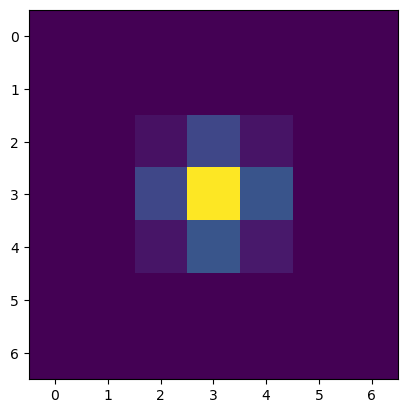

In [19]:
plt.imshow(cell_probabilities)

In [20]:
source_cell_shape = np.array(cell_size_standard)

# Splitting the center cell grid into subcells
sub_cell_size_standard = (source_cell_shape / source_cell_resolution).astype(int)
sub_cell_size_overflow = (source_cell_shape % source_cell_resolution).astype(int)

sub_cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(source_cell_resolution, sub_cell_size_standard, sub_cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    if ax_overflow > 0:
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
    sub_cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
sub_cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in sub_cell_sizes]

sub_cell_lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in sub_cell_edges], indexing='ij')]).T
sub_cell_upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in sub_cell_edges], indexing='ij')]).T

# Finding the center cell and its lower bound
center_cell = np.ravel_multi_index(np.floor(cells/2).astype(int), cells)
lower_bound_center_cell = lower_bounds[center_cell]

sub_grid_cell_probabilities = np.full(source_cell_resolution, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(source_cell_resolution))), sub_cell_lower_bounds, sub_cell_upper_bounds):
    lower_b += lower_bound_center_cell
    upper_b += lower_bound_center_cell
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    sub_grid_cell_probabilities[*cell] = np.average(probability_map[*slices].astype(float))

In [21]:
indices_array = np.array(indices_list)
relative_indices = indices_array[:,:len(cells)] - indices_array[:,len(cells):]

# Shifting the relative positions by the position of the center
center_pos = (cells / 2).astype(int)
centered_positions = relative_indices + center_pos

# Filtering to the valid centered positions
valid_positions = np.all((centered_positions >= 0) & (centered_positions < cells), axis=1)
filtered_centered_positions = centered_positions[valid_positions]
filtered_indices_array = indices_array[valid_positions]

# Gathering the cell_probabilities
odor_probabilities = np.zeros((*cells, *cells), dtype=float)
odor_probabilities[*filtered_indices_array.T] = cell_probabilities[*filtered_centered_positions.T]

In [22]:
# Generating an empty observation matrix
observations = np.zeros((len(state_labels), len(action_set), len(observation_labels)))

# Filling the something/nothing observations
agent_cells = indices_array[:np.prod(cells),2:]
sub_cell_cues = sub_grid_cell_probabilities[*np.array(list(np.ndindex(tuple(source_cell_resolution)))).T]
for obs_i, agent_cell in enumerate(agent_cells):
    # For observation matrix
    agent_ids_in_states = (np.arange(np.prod(cells)) * cell_count) + obs_i

    # To read odor probability matrix
    agent_ids_in_space = np.all(indices_array[:,2:] == agent_cell, axis=1)
    filtered_agent_ids_in_space = indices_array[agent_ids_in_space]

    # Setting the probabilities in the matrix
    probabilities_at_agent_position = odor_probabilities[*filtered_agent_ids_in_space.T][:,None]
    observations[agent_ids_in_states,:,obs_i] = 1 - probabilities_at_agent_position # Nothing
    observations[agent_ids_in_states,:,obs_i+len(agent_cells)] = probabilities_at_agent_position # Something

    # Finding sub-cells of the source cell
    sub_cell_source_ids = (cell_count**2) + np.arange(np.prod(source_cell_resolution))
    observations[sub_cell_source_ids,:,obs_i] = (1 - sub_cell_cues[:,None]) / cell_count # Nothing
    observations[sub_cell_source_ids,:,obs_i+len(agent_cells)] = sub_cell_cues[:,None] / cell_count # Something

    # Finding the cells where the agent is at the source
    agent_at_source_id = (obs_i * cell_count) + obs_i
    observations[agent_at_source_id,:,obs_i] = 1.0 # Nothing
    observations[agent_at_source_id,:,obs_i+len(agent_cells)] = 0.0 # Something


# Goal observations
observations[-1,:,0] = 0.0
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

assert np.all(observations.sum(axis=-1).round(8) == 1.0)

### Model

In [23]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [len(state_labels)-1], # The very last state is the goal state
    seed=12131415
)

## Training Agent

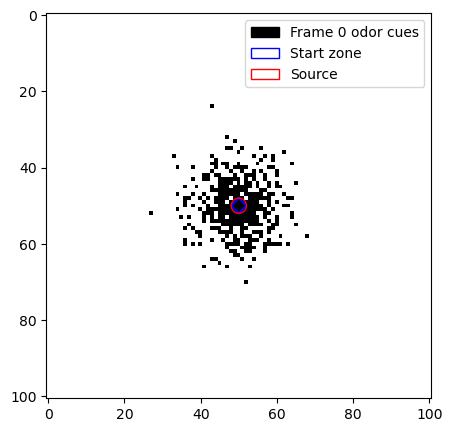

In [24]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              boundary_condition='stop',
                              start_zone='data_zone',
                              odor_present_threshold=3e-1)

artificial_env.plot()

## FSVI agent

In [25]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [26]:
_ = ag.train(expansions=300, use_gpu=True)

[11/20/2024, 13:32:57] MDP_policy, not provided. Solving MDP with Value Iteration...
[11/20/2024, 13:32:57] Sending Model to GPU...
[11/20/2024, 13:32:58]     > Done in 0.414s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 2451-state, 4-action
  - Converged in 918 iterations and 1.3453 seconds
  - Took on average 0.0015s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 2451 state, 4 action, 99 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 1576 alpha vectors.
  - Converged in 108.5975s

  - Expand function took on average 0.0129s and yielded on average 951.70 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.3491s and yielded on average 5.24 alpha vectors per iteration. (0.0004s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


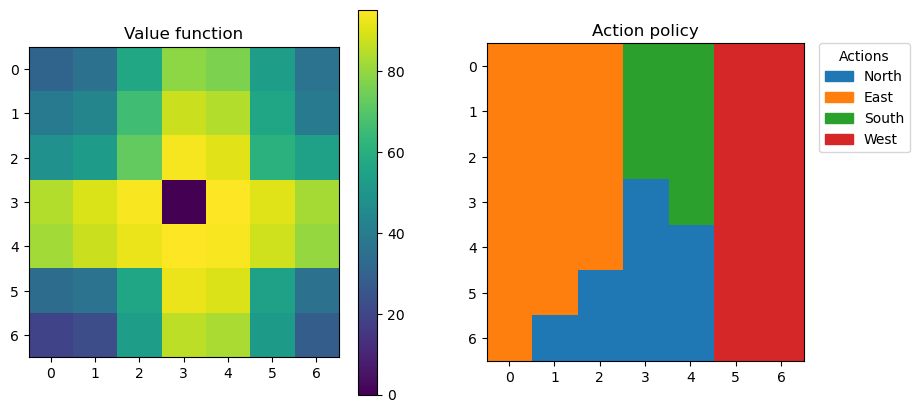

In [28]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [0,0]
source_policy_id = np.arange(np.prod(cells)).reshape(cells)[*source_policy]
# source_state_start = source_policy_id * np.prod(cells)
source_state_start = np.prod(cells) ** 2

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+np.prod(cells)]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+np.prod(cells)]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

## Testing agent

In [29]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [30]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

### Running test

In [31]:
hist = run_test(ag,
                n=n,
                horizon=1000,
                start_points=start_points,
                environment=env,
                use_gpu=True)

Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 131.103s:
Simulations reached goal: 4957/10188 (5231 failures (reached horizon: 5231)) (48.66% success)
 - Average step count:                 747.654 +- 320.71 (Successful only: 481.359 +- 270.74)
 - Extra steps:                        699.096 +- 321.37 (Successful only: 432.286 +- 270.55)
 - Average discounted rewards (ADR):   0.036 +- 0.10 (Successful only: 0.075 +- 0.14)
 - Tmin/T:                             0.103 +- 0.12 (Successful only: 0.161 +- 0.15)


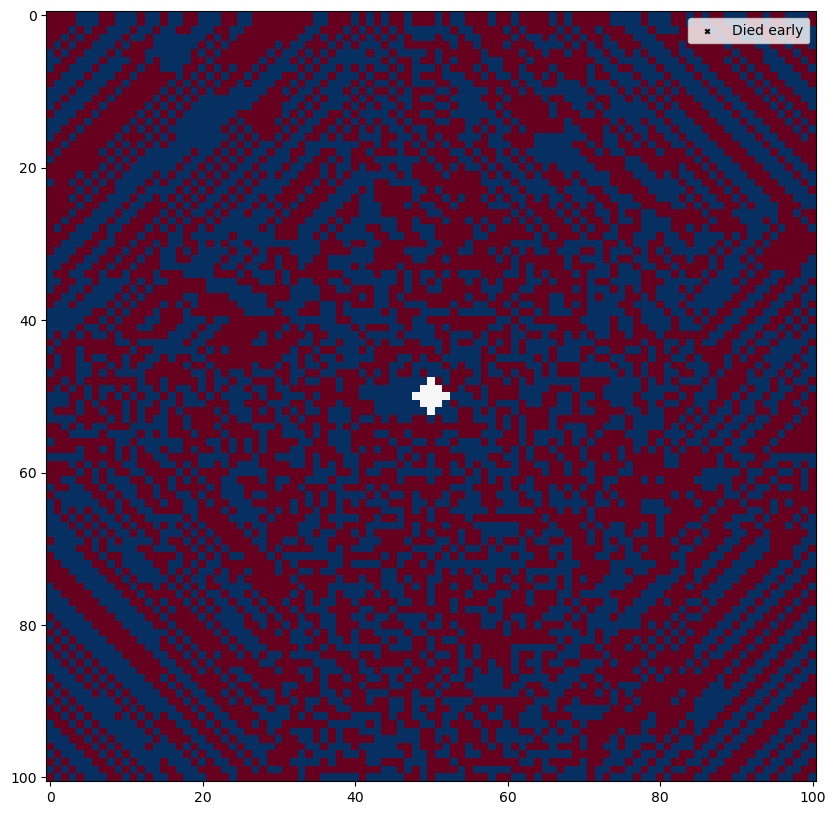

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

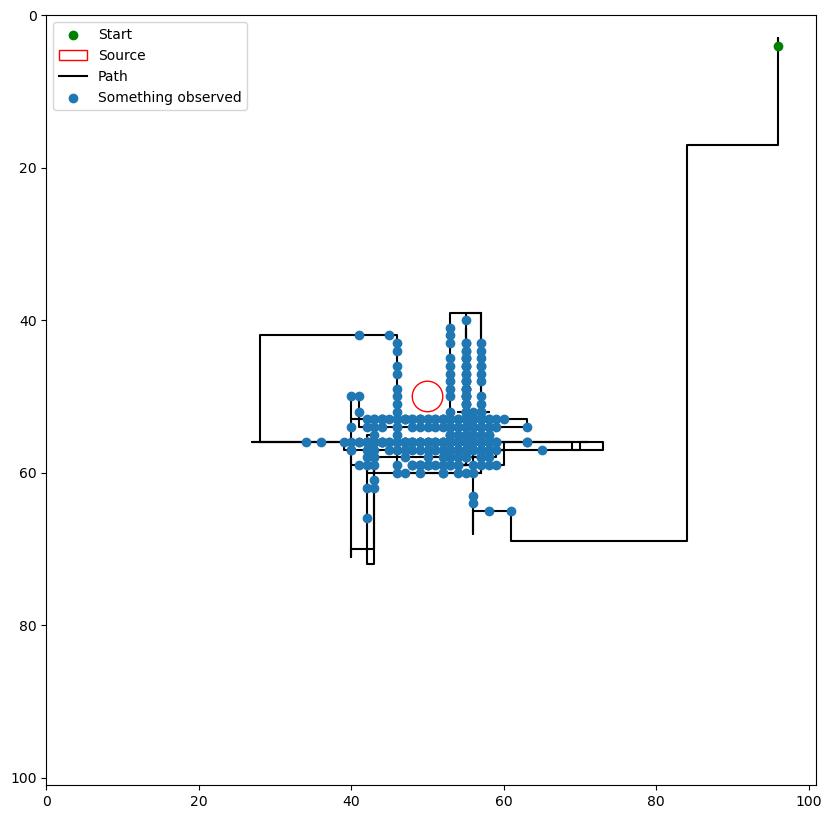

In [37]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(500, ax= ax)

In [34]:
hist.simulation_dfs[19]

,time,y,x,dy,dx,o,reached_source
0,0,0,19,None,None,None,None
1,1,0,19,-1,0,0.0,0
2,2,0,20,0,1,0.0,0
3,3,0,21,0,1,0.0,0
4,4,0,22,0,1,0.0,0
...,...,...,...,...,...,...,...
996,996,58,42,-1,0,0.0,0
997,997,57,42,-1,0,1.0,0
998,998,56,42,-1,0,0.0,0
999,999,56,43,0,1,0.0,0
